In [30]:
#! R

##import kallisto, make Poisson heatmap plot and PCA
##load libraries
libs <- c("sleuth","tidyverse","biomaRt","pheatmap","RColorBrewer","PoiClaClu","DESeq2","rhdf5","ggplot2","devtools","cowplot", "reshape2", "limma", "edgeR", "DESeq2")
libsLoaded <- lapply(libs,function(l){suppressWarnings(suppressMessages(library(l, character.only = TRUE)))})

##input parameters
BASEDIR <- "../"
DATADIR <- paste0(BASEDIR, "analysis/RNAseq")
OUTDIR <- paste0(DATADIR, "/kallisto-sleuth_any-no_corfit")
RDATADIR <- paste0(OUTDIR, "/RData")
SHARDATADIR <- paste0(BASEDIR, "/analysis/RNAseq/shared_RData")
dir.create(RDATADIR, showWarnings=FALSE, recursive=TRUE)
dir.create(SHARDATADIR, showWarnings=FALSE, recursive=TRUE)

CLIN <- paste0(BASEDIR, "data/rdl_RNAseq.metadata.tsv")
metadata <- read_tsv(CLIN) %>%
            dplyr::filter(! sampleID %in% c("S2","S12")) %>%
            dplyr::filter(! Tissue %in% c("Normal","Normal_Tumour")) %>%
            dplyr::mutate(path = file.path(DATADIR, sampleID, "kallisto", "abundance.h5")) %>%
            dplyr::rename("sample" = sampleID) %>%
            dplyr::mutate(Individual = paste0("R", Individual)) %>%
            dplyr::filter(Diet %in% "HFD") %>%
            dplyr::mutate(Int_Any = unlist(lapply(Intervention, function(f){
                                            if(f=="NO"){return("NO")}
                                            else{return("YES")}
                                    })))
 
##source plotting functions
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/poissonHeatmap.func.R")
source("https://raw.githubusercontent.com/brucemoran/R/master/functions/plot/pcaPlot.func.R")

##input parameters for loading sleuth data
memfree <- as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))
ramPerCoreGB <- 15
threadAlloc <- round((memfree/1000000)/ramPerCoreGB, 0)-1


Parsed with column specification:
cols(
  sampleID = col_character(),
  Individual = col_double(),
  Tissue = col_character(),
  Diet = col_character(),
  Intervention = col_character(),
  Batch = col_character()
)



In [21]:
##txp2gene annotation
##rat-human annotation
OUTPUT <- paste0(SHARDATADIR, "/tx2gene.gene2ext.human_rat_intersect_anno.RData")
if(!file.exists(OUTPUT)){
    RGENOME <- "rnorvegicus_gene_ensembl"
    HGENOME <- "hsapiens_gene_ensembl"
    rmart <- biomaRt::useMart(biomart = "ensembl", dataset = RGENOME)
    hmart <- biomaRt::useMart(biomart = "ensembl", dataset = HGENOME)

    tx2gene <- biomaRt::getBM(attributes=c("ensembl_transcript_id", "ensembl_gene_id", "external_gene_name"), mart = hmart)
    colnames(tx2gene)[1] <- "target_id"
    gene2ext <- biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)

    rtx2gene <- as_tibble(biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = rmart)) %>%
                dplyr::arrange(external_gene_name) %>%
                dplyr::mutate(human_external_gene_name = toupper(external_gene_name))
    htx2gene <- as_tibble(biomaRt::getBM(attributes=c("ensembl_gene_id", "external_gene_name"), mart = hmart)) %>%
                dplyr::arrange(external_gene_name) %>%
                dplyr::rename(human_external_gene_name = "external_gene_name")
    rhtx2gene <- inner_join(rtx2gene, htx2gene, by="human_external_gene_name")
    rhtx2gene <- rhtx2gene %>% dplyr::rename(ensembl_gene_id = "ensembl_gene_id.x", human_ensembl_gene_id = "ensembl_gene_id.y")
    save(tx2gene, gene2ext, rhtx2gene, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

In [22]:
##read sleuth inputs
OUTPUT <- paste0(RDATADIR, "/sleuthObject.full.RData")
if(!file.exists(OUTPUT)){
    h5closeAll()
    so <- sleuth_prep(metadata,
                      full_model =~ Batch,
                      target_mapping = tx2gene,
                      aggregation_column = "ensembl_gene_id", 
                      gene_mode = TRUE,
                      num_cores = threadAlloc,
                      max_bootstrap = 50)
    save(so, metadata, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}

Warning message in check_quant_mode(obj, units):
"your sleuth object is in gene mode, but you selected 'est_counts'. Selecting 'scaled_reads_per_base'..."

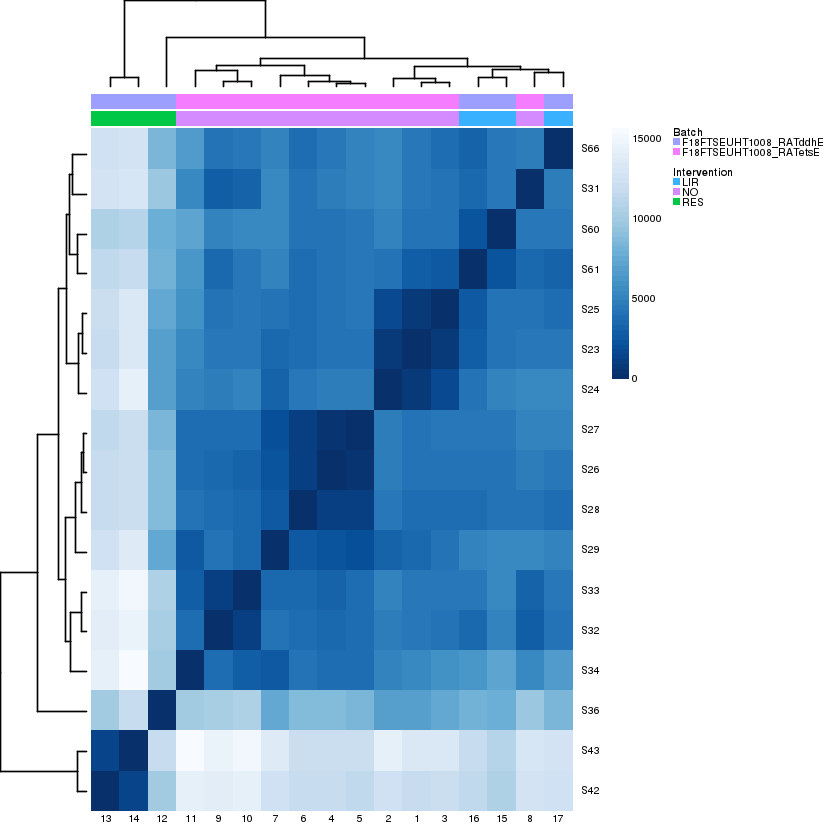

Saving 6.67 x 6.67 in image
Warning message in check_quant_mode(obj, units):
"your sleuth object is in gene mode, but you selected 'est_counts'. Selecting 'scaled_reads_per_base'..."

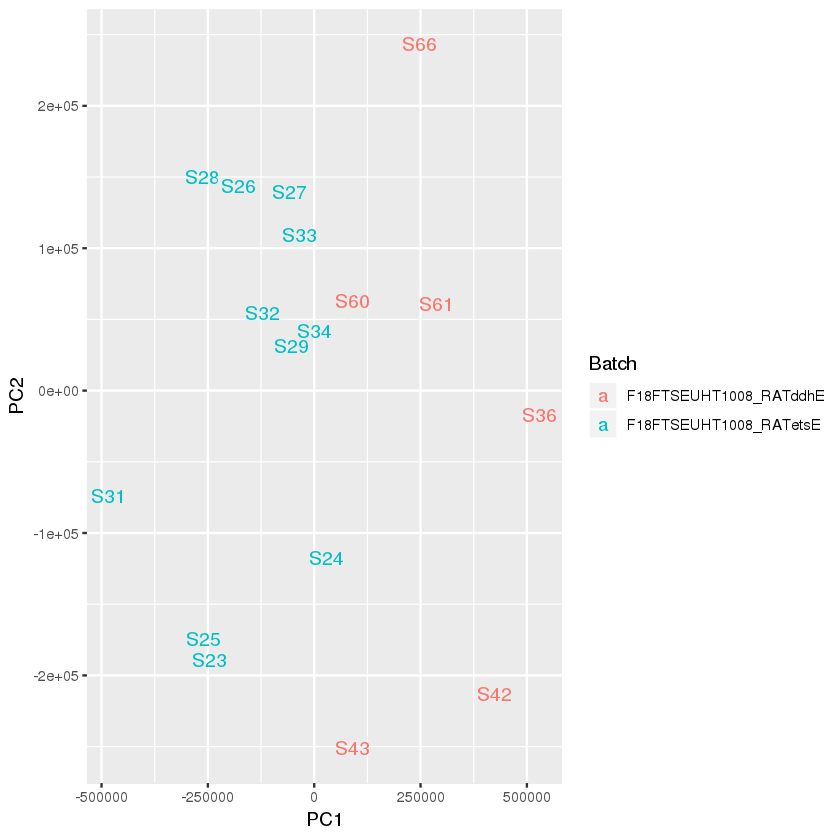

Saving 6.67 x 6.67 in image
Warning message in check_quant_mode(obj, units):
"your sleuth object is in gene mode, but you selected 'est_counts'. Selecting 'scaled_reads_per_base'..."

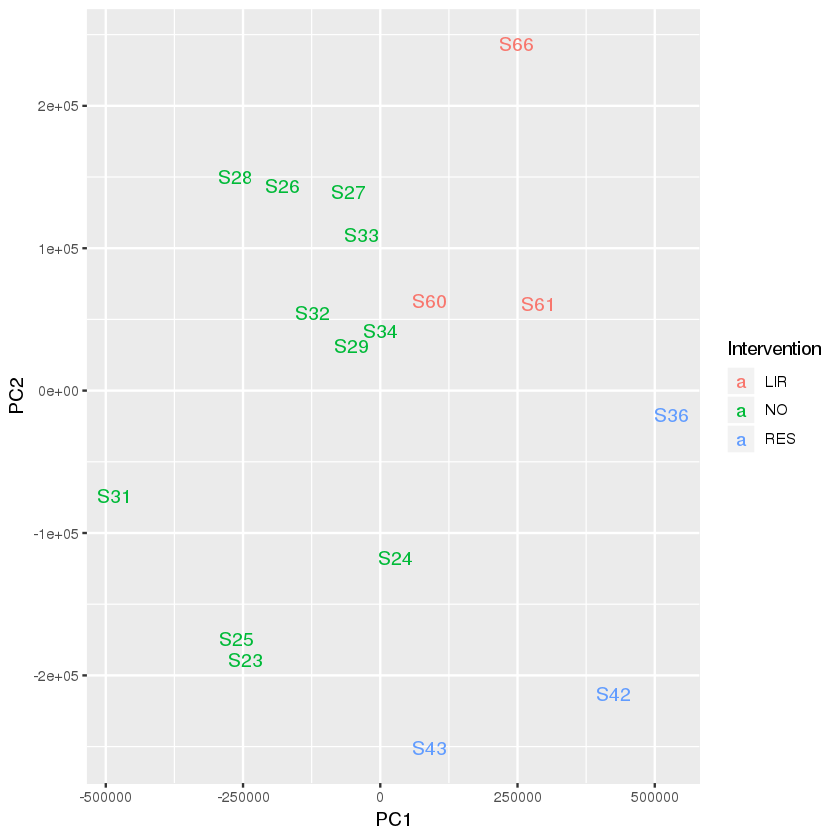

Saving 6.67 x 6.67 in image


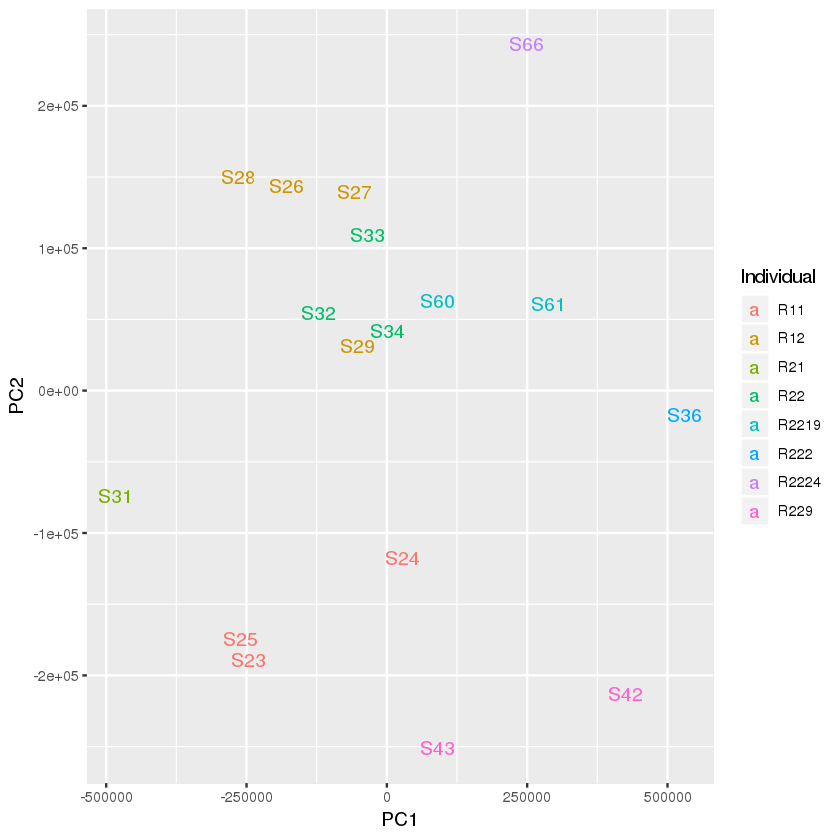

In [36]:
#QC plots
pois <- poissonHeatmap(input=so, fontsize=6, ann=metadata, anncols=c("Batch", "Intervention"))
plot_pca(so, alpha=0.3, text_labels = TRUE, color_by = "Batch"); ggsave(file="plot_pca.qc.Batch.pdf")
plot_pca(so, alpha=0.3, text_labels = TRUE, color_by = "Intervention"); ggsave(file="plot_pca.qc.Intervention.pdf")
plot_pca(so, alpha=0.3, text_labels = TRUE, color_by = "Individual"); ggsave(file="plot_pca.qc.Individual.pdf")


In [23]:
##counts from gene_mode (non-integer) sleuth object
OUTPUT <- paste0(RDATADIR, "/obs_norm_filt_df.conds.all.RData")
if(!file.exists(OUTPUT)){

    ##create DF
    obs_norm_filt_df <- dcast(so$obs_norm_filt, 
                              target_id ~ sample, 
                              value.var="scaled_reads_per_base") %>% 
                        dplyr::rename("ensembl_gene_id" = target_id) %>%
                        dplyr::arrange(ensembl_gene_id) %>%
                        dplyr::mutate_if(is.numeric, round, 0) %>%
                        as.data.frame() %>%
                        column_to_rownames(., var="ensembl_gene_id")
    
    ##input conditions
    conds <- metadata %>% dplyr::select(sample, Individual, Intervention, Int_Any, Batch) %>% as.data.frame() 
    conds[] <- lapply(conds, factor)
  
    save(obs_norm_filt_df, conds, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


Warning message:
“Removed 2079 rows containing non-finite values (stat_density).”


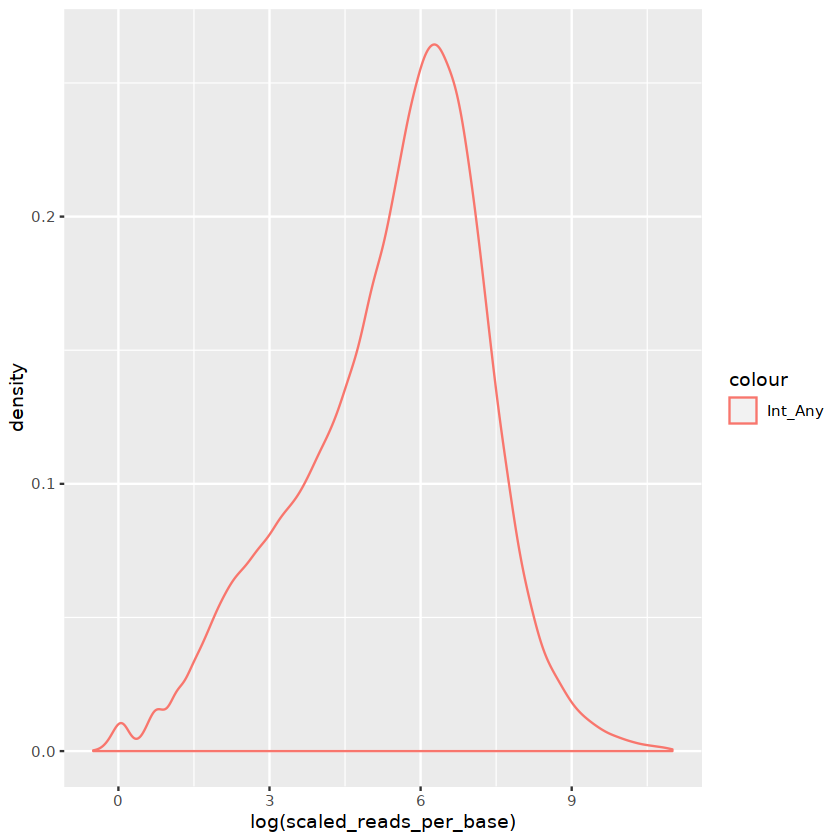

In [24]:
##distribution of log(scaled_reads_per_base) to filter low expression
OUTPUT <- paste0(RDATADIR, "/obs_norm_filt2_df.conds.RData")
if(!file.exists(OUTPUT)){
    
    ##v. similar distribution for Tissue, Batch and other factors
    ##indciates log(3) as cutoff generally, =~20 scaled_reads_per_base
    sot <- so$obs_norm_filt
    ggp <- ggplot() + 
           geom_density(data=sot, aes(log(scaled_reads_per_base), colour="Int_Any")) +
           xlim(c(-0.5,11))

    ##filter obs_norm_filt_df
    print(paste0("Sleuth filtered: ", dim(obs_norm_filt_df), " genes"))
    obs_norm_filt2_df <- as_tibble(obs_norm_filt_df, 
                                    rownames="ensembl_gene_id") %>% 
                         dplyr::mutate(mean = rowMeans(dplyr::select_if(., is.numeric))) %>%
                         dplyr::filter(mean > 20) %>% 
                         dplyr::select(-mean) %>%
                         column_to_rownames("ensembl_gene_id")
    print(paste0("Density filtered: ", dim(obs_norm_filt2_df), " genes"))

    save(ggp, obs_norm_filt2_df, conds, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}
ggp


In [25]:
##limma-voom including duplicateCorrelation as multiple Individuals have several replicates
OUTPUT <- paste0(RDATADIR, "/limma-voom.DGEList-NOTcorfit.RData")
if(!file.exists(OUTPUT)){
    
    ##make input model.matrix design
    mmdf <- data.frame(Contrasts=conds$Int_Any)
    all.design <- model.matrix(~0 + Contrasts, data = mmdf)
    colnames(all.design) <- c(levels(mmdf$Contrasts))
    
    ##make DGEList from filtered counts
    all.dge <- DGEList(counts=obs_norm_filt2_df)
    all.keep <- filterByExpr(all.dge, 
                             all.design)
    all.dge <- all.dge[all.keep, 
                       keep.lib.sizes=FALSE]
    all.dge <- calcNormFactors(all.dge, 
                               method="TMM")
    
    ##voom, with 2 rounds of dupcor
    all.voom <- voom(all.dge, 
                     all.design) 
    
    ##fit
    all.fit <- lmFit(all.voom, 
                     all.design)
    
    save(mmdf, all.design, all.voom, all.fit, file=OUTPUT)
}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}


In [26]:
##contrasts applied to tumour, normal across desired comparisons
OUTPUT <- paste0(RDATADIR, "/limma-voom.contrastOut.NOTcorfit.RData")
if(!file.exists(OUTPUT)){

    cont.matrix <- makeContrasts(
        HFD_vs_ANY=NO-YES,
        levels=all.design)
    all.fit2 <- contrasts.fit(all.fit, cont.matrix)
    all.fite <- eBayes(all.fit2, robust=TRUE)
    contrastOut <- topTable(all.fite, number=Inf, coef="HFD_vs_ANY")
    
    contrastSig <- as_tibble(contrastOut, rownames="ensembl_gene_id") %>% 
                     inner_join(rhtx2gene,.) %>% 
                     dplyr::filter(adj.P.Val < 0.1) %>%
                     dplyr::select(ensembl_gene_id, external_gene_name, human_external_gene_name, human_ensembl_gene_id, logFC, adj.P.Val) %>%
                     dplyr::mutate_if(is.numeric, round, 3) %>%
                     dplyr::arrange(desc(logFC))

    save(contrastOut, contrastSig, all.fit2, all.fite, file=OUTPUT)

}
if(file.exists(OUTPUT)){
    load(OUTPUT)
}
dim(contrastSig)

[1] 4158    6

In [27]:
contrastSig

ensembl_gene_id,external_gene_name,human_external_gene_name,human_ensembl_gene_id,logFC,adj.P.Val
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
ENSRNOG00000050978,Hmgn1,HMGN1,ENSG00000205581,6.778,0.023
ENSRNOG00000032885,Cycs,CYCS,ENSG00000172115,5.571,0.016
ENSRNOG00000008422,Lpo,LPO,ENSG00000167419,5.482,0.007
ENSRNOG00000029889,Clca4,CLCA4,ENSG00000016602,4.931,0.073
ENSRNOG00000016953,Chst4,CHST4,ENSG00000140835,4.778,0.007
ENSRNOG00000019134,Htr4,HTR4,ENSG00000164270,4.724,0.010
ENSRNOG00000007247,A2ml1,A2ML1,ENSG00000166535,4.712,0.009
ENSRNOG00000009168,Sprr2d,SPRR2D,ENSG00000163216,4.500,0.049
ENSRNOG00000058193,Slc27a6,SLC27A6,ENSG00000113396,4.350,0.060


In [12]:
write_excel_csv(x=contrastSig, 
                path=paste0(OUTDIR, "/rat_diet_liraglutide.Tumour_HFD_NO-ANY.DE.NOTcorfit.csv"),
                col_names=TRUE,,
                append=FALSE)


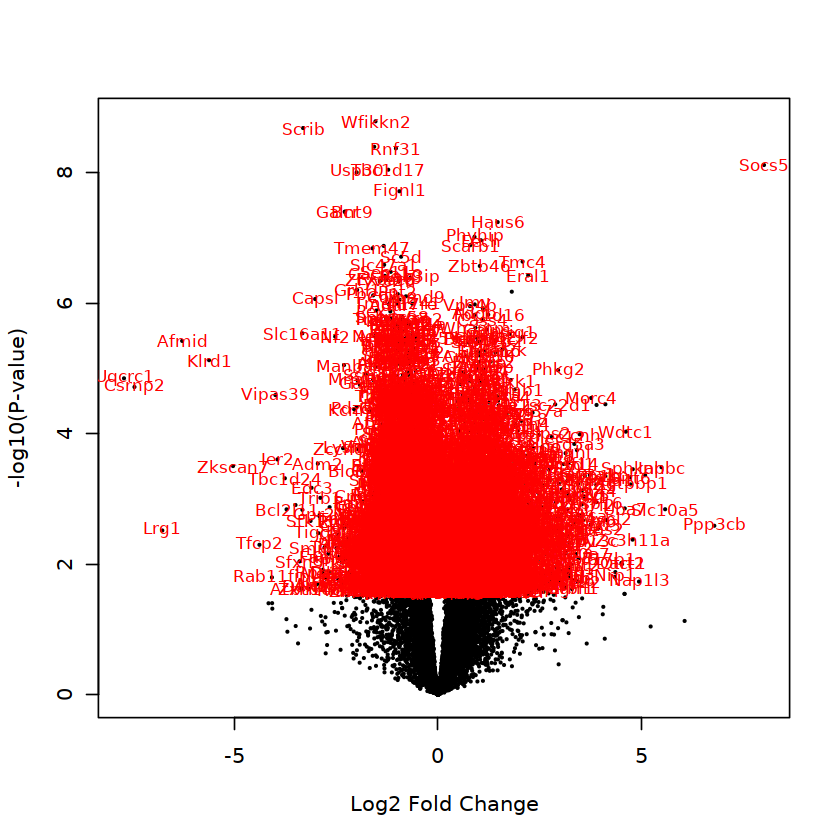

In [29]:
all.fite$names <- rhtx2gene %>% 
                  dplyr::filter(ensembl_gene_id %in% rownames(all.fite$coefficients)) %>%
                  dplyr::arrange(ensembl_gene_id) %>%
                  dplyr::select(external_gene_name) %>% 
                  unlist()
#pdf("rat-diet-liraglutide_RNAseq.Tumour_NO-INT_NOT-CONS-CORR.volcano.pdf")
    volcanoplot(all.fite, coef = "HFD_vs_ANY", style = "p-value", highlight = dim(contrastSig)[1], hl.col="red",
                xlab = "Log2 Fold Change", ylab = NULL, pch=16, cex=0.35, names=all.fite$names)
#dev.off()

In [45]:
top.tibble.sig <- contrastSig %>% dplyr::filter(logFC %in% c(head(logFC, 10), tail(logFC, 10)))
NO_vs_ANYup <- unlist(top.tibble.sig[c(1:10), "ensembl_gene_id"])
NO_vs_ANYdown <- unlist(top.tibble.sig[c(11:20), "ensembl_gene_id"])

pdf("rat-diet-liraglutide_RNAseq.Tumour_NO-INT_NOT-CONS-CORR.topDEGs.pdf")
    plotExps(log2(obs_norm_filt2_df), genes=NO_vs_ANYup, mapgenes=rhtx2gene, conds, condcol="Int_Any", factors=c("NO", "YES"), tag="Int_Any, Up in NO")
    plotExps(log2(obs_norm_filt2_df), genes=NO_vs_ANYdown, mapgenes=rhtx2gene, conds, condcol="Int_Any", factors=c("NO", "YES"), tag="Int_Any, Down in NO")
dev.off()

No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 24 rows containing non-finite values (stat_boxplot)."No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables
No id var

png 
  2

In [15]:
plotExps <- function(log2tpms, genes, mapgenes, conds, condcol, factors, tag){

    log2tpms_genes <- log2tpms[match(genes,rownames(log2tpms)),]
    if(dim(log2tpms_genes)[1]==0){
        print("No input found, check genes are in rownames of log2tpm input")
    }
    else{
        Factor <- rep(factors[1],dim(conds)[1])
        Factor[c(conds[condcol] == factors[2])]<-factors[2]
        
        mltgg <- data.frame(0,0,0)
        mltgg <- mltgg[-1,]
        genenames <- mapgenes %>% dplyr::filter(ensembl_gene_id %in% unlist(genes)) %>% dplyr::select(human_external_gene_name)
        genenames <- unlist(genenames)

        for(xx in 1:length(genes)){
          mltgg <- rbind(mltgg, cbind(rep(genenames[xx], length(Factor)),
                                      melt(log2tpms_genes[rownames(log2tpms_genes) %in% unlist(genes)[xx],]),
                                      Factor))
        }
        
        colnames(mltgg) <- c("Gene","sample","value","Factor")
        mltgg$Factor <- factor(mltgg$Factor,
                               levels = factors, 
                               ordered = TRUE)
        ggp <- ggplot(data = mltgg, aes(x = Gene, y = value)) +
               geom_boxplot(aes(colour = Factor)) +
               geom_jitter(aes(colour = Factor), position=position_dodge(0.8)) +
               labs(y = "log2TPM", title = paste0(tag, ": Expression per Group per Gene")) +
               scale_colour_manual(values = c("blue", "red")) +
               theme(axis.text.x = element_text(angle = 45, hjust = 1))
    }
    return(ggp)
}


In [33]:
NOs <- metadata %>% dplyr::filter(Int_Any %in% "NO") %>% dplyr::select(sample) %>% unlist()
YESs <- metadata %>% dplyr::filter(Int_Any %in% "YES") %>% dplyr::select(sample) %>% unlist()

print("Mean counts per significant genes")
for(x in 1:length(top.tibble.sig$ensembl_gene_id)){
    gene <- top.tibble.sig$ensembl_gene_id[x]
    genename <- top.tibble.sig %>% dplyr::filter(ensembl_gene_id %in% gene) %>% dplyr::select("human_external_gene_name")
    NOmean <- round(rowMeans(obs_norm_filt2_df[gene, NOs]), 0)
    YESmean <- round(rowMeans(obs_norm_filt2_df[gene, YESs]), 0)
    NOsd <- round(sd(obs_norm_filt2_df[gene, NOs]), 0)
    YESsd <- round(sd(obs_norm_filt2_df[gene, YESs]), 0)
    logFC <- top.tibble.sig$logFC[x]
    print(paste0(genename, ": LogFC = ", logFC, "; NO: ", NOmean, " (sd=", NOsd, ") ; YES: ", YESmean, " (sd=", YESsd, ")"))
}


[1] "Mean counts per significant genes"
[1] "HMGN1: LogFC = 6.778; NO: 95 (sd=69) ; YES: 0 (sd=0)"
[1] "CYCS: LogFC = 5.571; NO: 52 (sd=33) ; YES: 1 (sd=2)"
[1] "LPO: LogFC = 5.482; NO: 9323 (sd=6449) ; YES: 521 (sd=521)"
[1] "CLCA4: LogFC = 4.931; NO: 4788 (sd=7423) ; YES: 228 (sd=445)"
[1] "CHST4: LogFC = 4.778; NO: 1584 (sd=1337) ; YES: 108 (sd=126)"
[1] "HTR4: LogFC = 4.724; NO: 65 (sd=91) ; YES: 2 (sd=5)"
[1] "A2ML1: LogFC = 4.712; NO: 25932 (sd=35750) ; YES: 1332 (sd=1329)"
[1] "SPRR2D: LogFC = 4.5; NO: 87 (sd=110) ; YES: 2 (sd=3)"
[1] "SLC27A6: LogFC = 4.35; NO: 276 (sd=302) ; YES: 30 (sd=40)"
[1] "LRRC26: LogFC = 4.333; NO: 89 (sd=66) ; YES: 10 (sd=17)"
[1] "SFRP5: LogFC = -3.123; NO: 7 (sd=5) ; YES: 101 (sd=114)"
[1] "B4GALNT3: LogFC = -3.161; NO: 9 (sd=7) ; YES: 240 (sd=307)"
[1] "RPL13: LogFC = -3.349; NO: 1158 (sd=715) ; YES: 6280 (sd=2913)"
[1] "SCCPDH: LogFC = -3.395; NO: 203 (sd=189) ; YES: 382 (sd=93)"
[1] "GPC3: LogFC = -3.493; NO: 49 (sd=42) ; YES: 782 (sd=773)"
[1] "

ensembl_gene_id,external_gene_name,human_external_gene_name,human_ensembl_gene_id,logFC,adj.P.Val
ENSRNOG00000050978,Hmgn1,HMGN1,ENSG00000205581,6.778,0.023
ENSRNOG00000032885,Cycs,CYCS,ENSG00000172115,5.571,0.016
ENSRNOG00000008422,Lpo,LPO,ENSG00000167419,5.482,0.007
ENSRNOG00000029889,Clca4,CLCA4,ENSG00000016602,4.931,0.073
ENSRNOG00000016953,Chst4,CHST4,ENSG00000140835,4.778,0.007
ENSRNOG00000032626,Mmp3,MMP3,ENSG00000149968,-4.071,0.067
ENSRNOG00000032832,Mmp10,MMP10,ENSG00000166670,-4.377,0.033
ENSRNOG00000004860,Myh9,MYH9,ENSG00000100345,-5.025,0.007
ENSRNOG00000048270,Knop1,KNOP1,ENSG00000103550,-6.273,0.001
ENSRNOG00000032605,Rpl32,RPL32,ENSG00000144713,-7.699,0.001


In [42]:
realDEgenes <- c('ENSRNOG00000011387', 'ENSRNOG00000011262', 'ENSRNOG00000001708', 'ENSRNOG00000005610', 'ENSRNOG00000005256', 'ENSRNOG00000019895', 'ENSRNOG00000019895', 'ENSRNOG00000002101', 'ENSRNOG00000020602', 'ENSRNOG00000021215', 'ENSRNOG00000052968', 'ENSRNOG00000033473', 'ENSRNOG00000058677', 'ENSRNOG00000005556', 'ENSRNOG00000060449', 'ENSRNOG00000031127', 'ENSRNOG00000003670', 'ENSRNOG00000037607') 
contrastSig %>% dplyr::filter(ensembl_gene_id %in% realDEgenes)

ensembl_gene_id,external_gene_name,human_external_gene_name,human_ensembl_gene_id,logFC,adj.P.Val
ENSRNOG00000011387,Tet3,TET3,ENSG00000187605,2.213,0.000
ENSRNOG00000011262,Bicra,BICRA,ENSG00000063169,0.897,0.000
ENSRNOG00000001708,Dvl3,DVL3,ENSG00000161202,0.793,0.000
ENSRNOG00000005610,Yipf4,YIPF4,ENSG00000119820,-0.786,0.000
ENSRNOG00000005256,Zc3h15,ZC3H15,ENSG00000065548,-0.947,0.000
ENSRNOG00000002101,Paics,PAICS,ENSG00000128050,-1.000,0.001
ENSRNOG00000019895,Nedd8,NEDD8,ENSG00000129559,-1.030,0.000
ENSRNOG00000019895,Nedd8,NEDD8,ENSG00000285246,-1.030,0.000
ENSRNOG00000021215,Rbm8a,RBM8A,ENSG00000265241,-1.202,0.000
ENSRNOG00000020602,Ndufa13,NDUFA13,ENSG00000186010,-1.219,0.000


In [46]:
getwd()


[1] "/data/genome/projects/rat-diet-liraglutide_RNAseq/analysis/RNAseq/jupyter_notebook"